# Image Transfer using Keras

In [310]:
import keras
import time
import keras.preprocessing.image as kpi
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b

In [311]:
# BASE_IMAGE = './cat.jpg'
# BASE_IMAGE = './IMG_20181015_184908.jpg'
# BASE_IMAGE = './mona-lisa.jpg'
BASE_IMAGE = './mona-pencil.jpg'

# STYLE_REFERENCE_IMAGE = './oil-painting.jpg'
# STYLE_REFERENCE_IMAGE = './some-abstract-painting.jpg'
# STYLE_REFERENCE_IMAGE = './triangles.jpg'
STYLE_REFERENCE_IMAGE = './triangles-2.jpg'
# STYLE_REFERENCE_IMAGE = './Abstract-Art-DURA-3.jpg'
# STYLE_REFERENCE_IMAGE = './pencil-red.jpg'
# STYLE_REFERENCE_IMAGE = './pencil-one.jpg'

RESULT_PREFIX = 'output/mona_triangles_1'

ITERATIONS = 10 # default : 10
CONTENT_WEIGHT = 0.5 # default : 0.025
STYLE_WEIGHT = 10.0 # default: 1.0
TV_WEGIHT = 10.0 # default: 1.0

In [312]:
width, height = kpi.load_img(BASE_IMAGE).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [313]:
def preprocess_image(image_path):
    img = kpi.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = kpi.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    
    return img

In [314]:
def deprocess_image(x):
    if keras.backend.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [315]:
base_image = keras.backend.variable(preprocess_image(BASE_IMAGE))
style_reference_image = keras.backend.variable(preprocess_image(STYLE_REFERENCE_IMAGE))

In [316]:
if keras.backend.image_data_format() == 'channels_first':
    combination_image = keras.backend.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = keras.backend.placeholder((1, img_nrows, img_ncols, 3))

In [317]:
input_tensor = keras.backend.concatenate([base_image,
                                         style_reference_image,
                                         combination_image], axis=0)

In [318]:
model = keras.applications.vgg19.VGG19(input_tensor=input_tensor,
                                weights='imagenet',
                                include_top=False)

In [319]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [320]:
def gram_matrix(x):
    assert keras.backend.ndim(x) == 3
    if keras.backend.image_data_format() == 'channels_first':
        features = keras.backend.batch_flatten(x)
    else:
        features = keras.backend.batch_flatten(keras.backend.permute_dimensions(x, (2, 0, 1)))
    gram = keras.backend.dot(features, keras.backend.transpose(features))
    return gram

In [321]:
def style_loss(style, combination):
    assert keras.backend.ndim(style) == 3
    assert keras.backend.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return keras.backend.sum(keras.backend.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [322]:
def content_loss(base, combination):
    return keras.backend.sum(keras.backend.square(combination - base))

In [323]:
def total_variation_loss(x):
    assert keras.backend.ndim(x) == 4
    if keras.backend.image_data_format() == 'channels_first':
        a = keras.backend.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = keras.backend.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = keras.backend.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = keras.backend.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return keras.backend.sum(keras.backend.pow(a + b, 1.25))


In [324]:
loss = keras.backend.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += CONTENT_WEIGHT * content_loss(base_image_features,
                                      combination_features)

In [325]:
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
total_variation_weight = TV_WEGIHT
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (STYLE_WEIGHT / len(feature_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [326]:
grads = keras.backend.gradients(loss, combination_image)

In [327]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = keras.backend.function([combination_image], outputs)

In [328]:
def eval_loss_and_grads(x):
    if keras.backend.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [329]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [330]:
x = preprocess_image(BASE_IMAGE)

Start of iteration 0
Current loss value: 64401950000.0


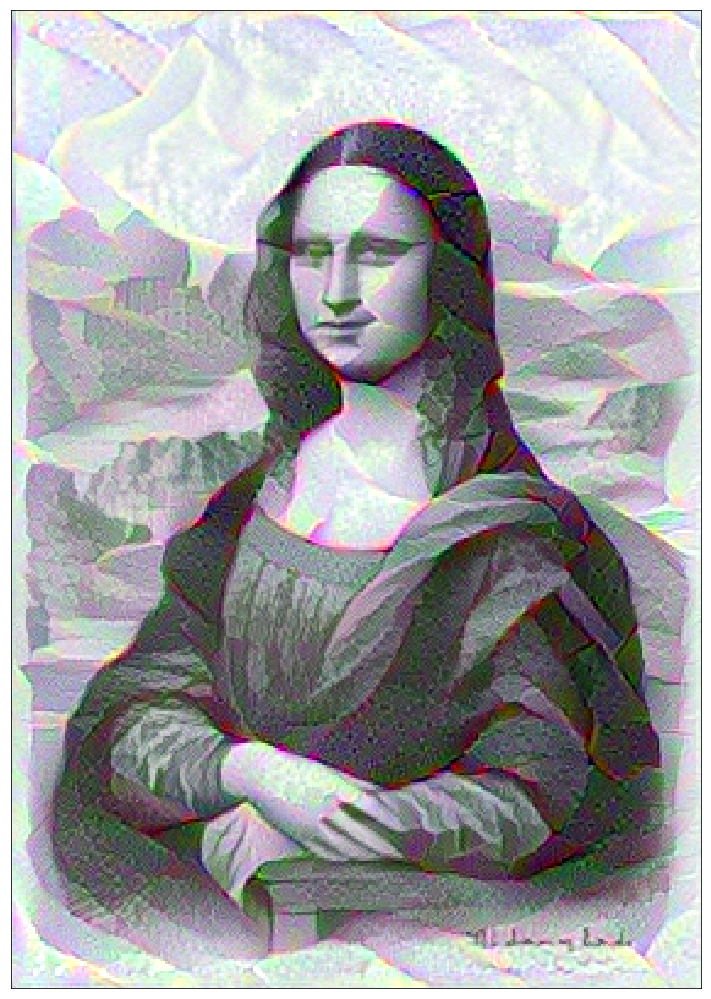

Image saved as output/mona_triangles_1_at_iteration_0.png
Iteration 0 completed in 11s
Start of iteration 1
Current loss value: 30951727000.0


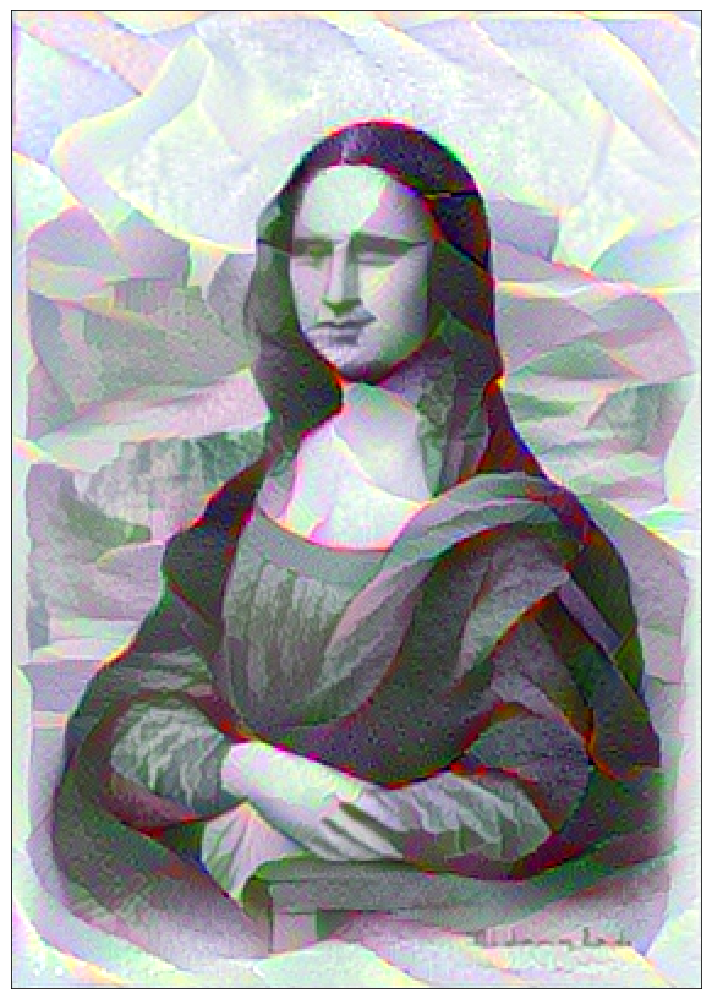

Image saved as output/mona_triangles_1_at_iteration_1.png
Iteration 1 completed in 9s
Start of iteration 2
Current loss value: 22536976000.0


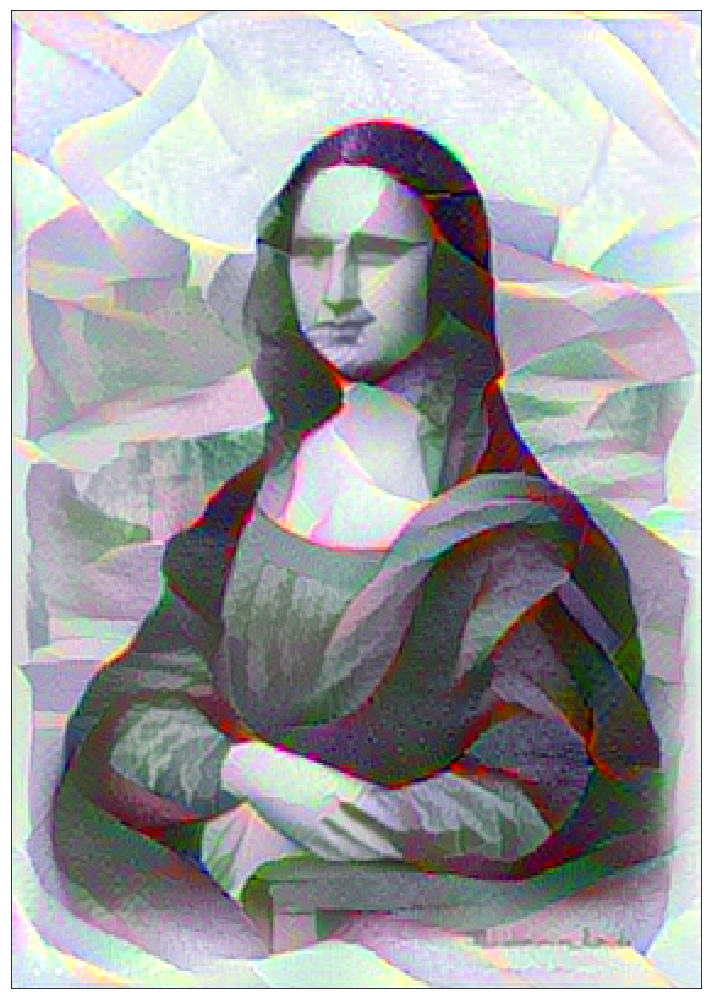

Image saved as output/mona_triangles_1_at_iteration_2.png
Iteration 2 completed in 11s
Start of iteration 3
Current loss value: 18531598000.0


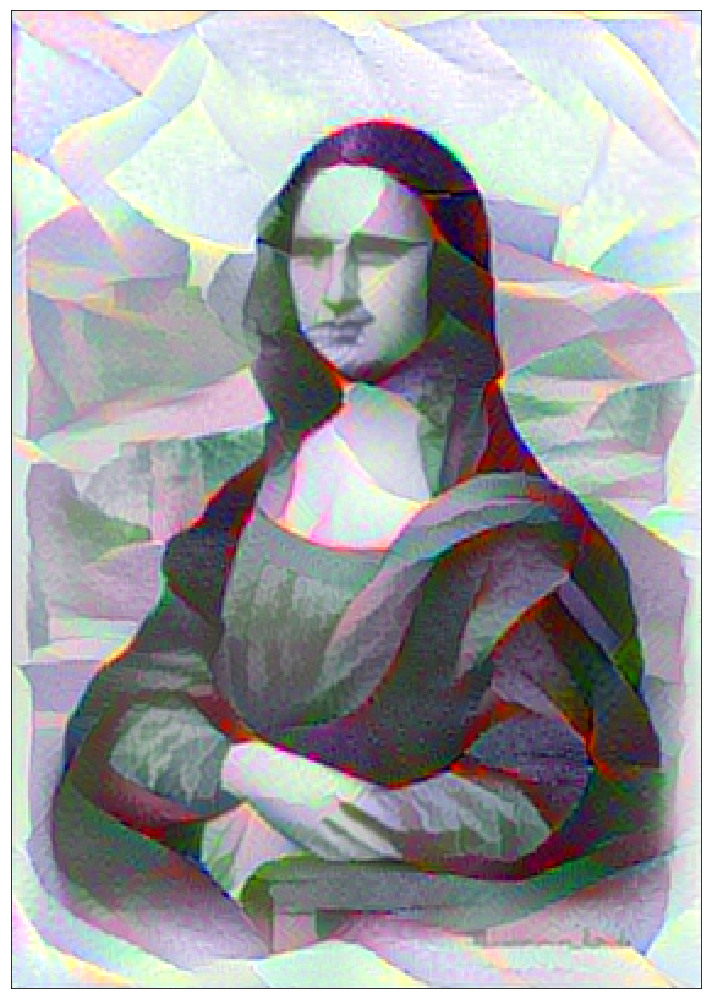

Image saved as output/mona_triangles_1_at_iteration_3.png
Iteration 3 completed in 11s
Start of iteration 4
Current loss value: 16513310000.0


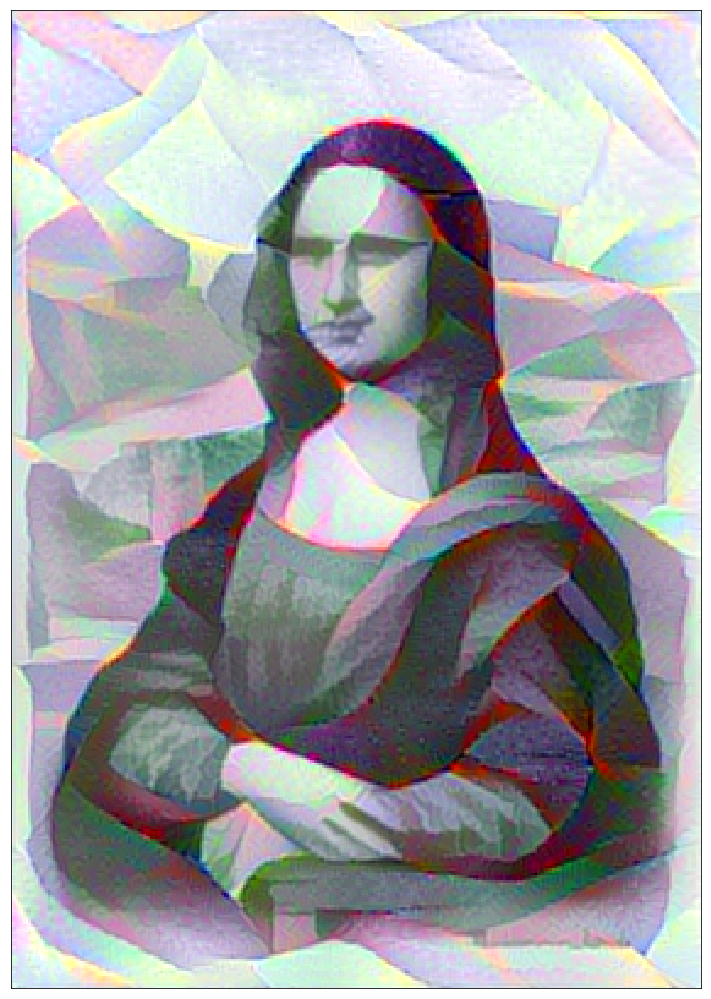

Image saved as output/mona_triangles_1_at_iteration_4.png
Iteration 4 completed in 10s
Start of iteration 5
Current loss value: 15101925000.0


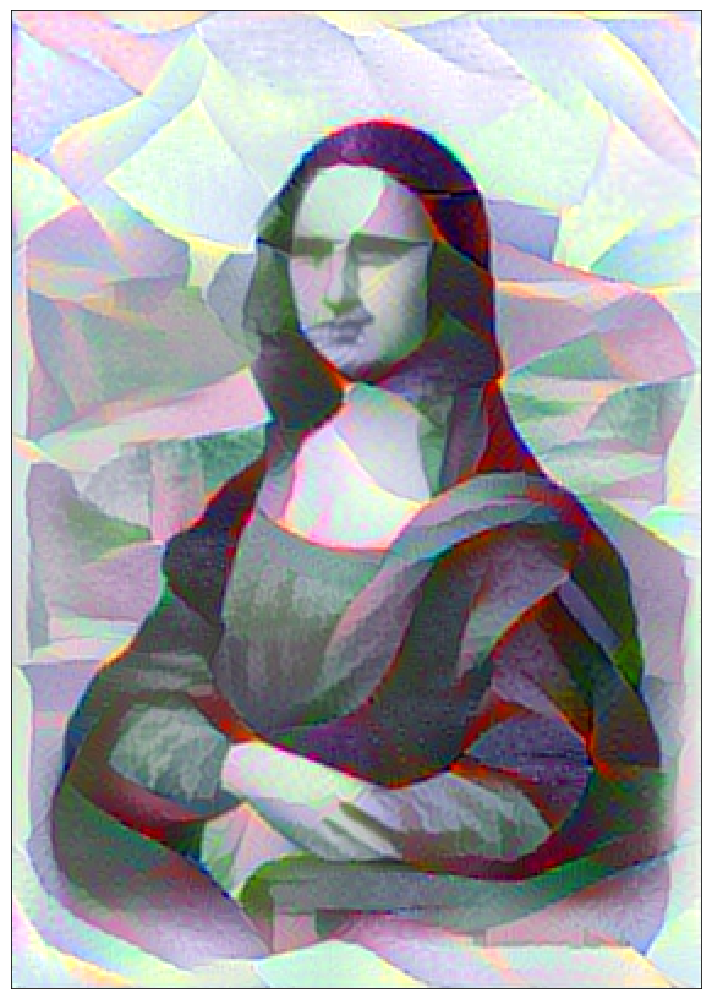

Image saved as output/mona_triangles_1_at_iteration_5.png
Iteration 5 completed in 10s
Start of iteration 6
Current loss value: 14098799000.0


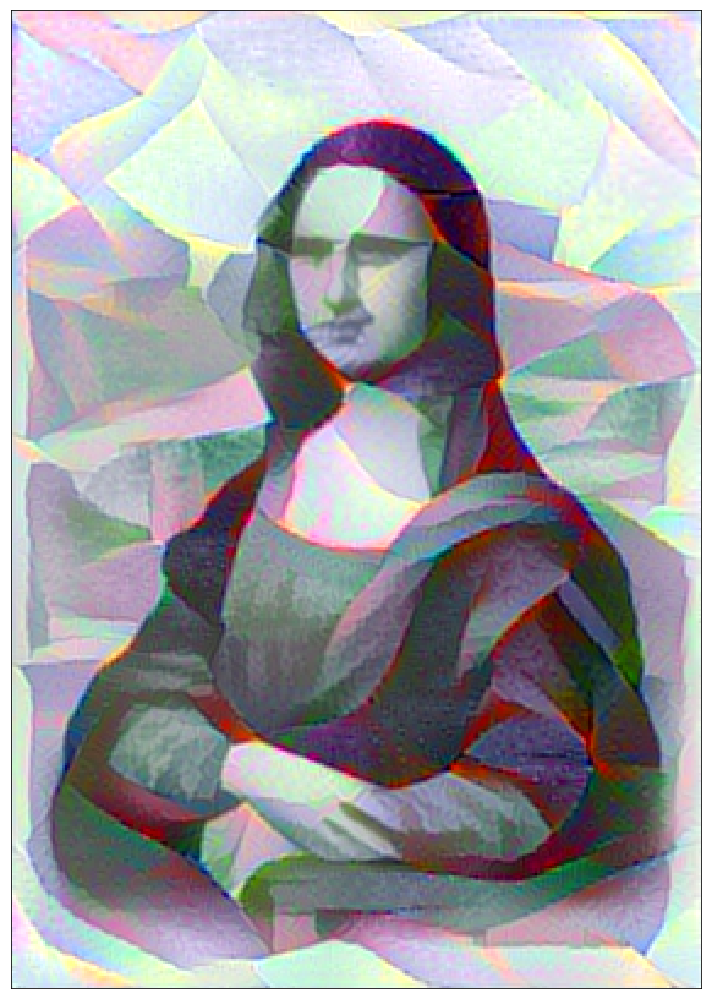

Image saved as output/mona_triangles_1_at_iteration_6.png
Iteration 6 completed in 9s
Start of iteration 7
Current loss value: 13285716000.0


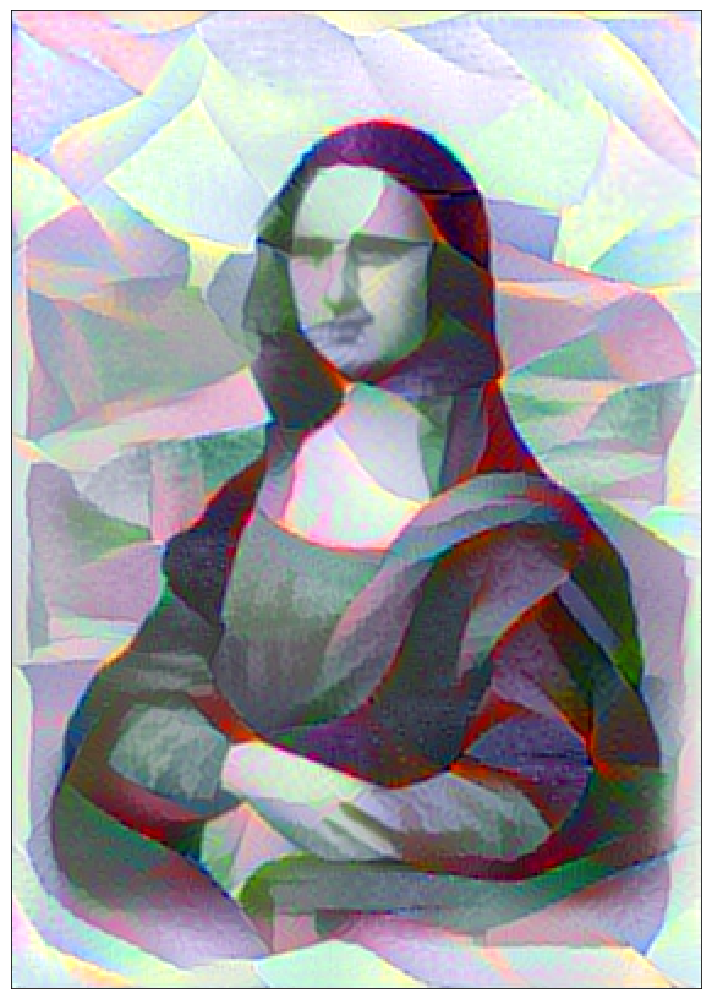

Image saved as output/mona_triangles_1_at_iteration_7.png
Iteration 7 completed in 10s
Start of iteration 8
Current loss value: 12699286000.0


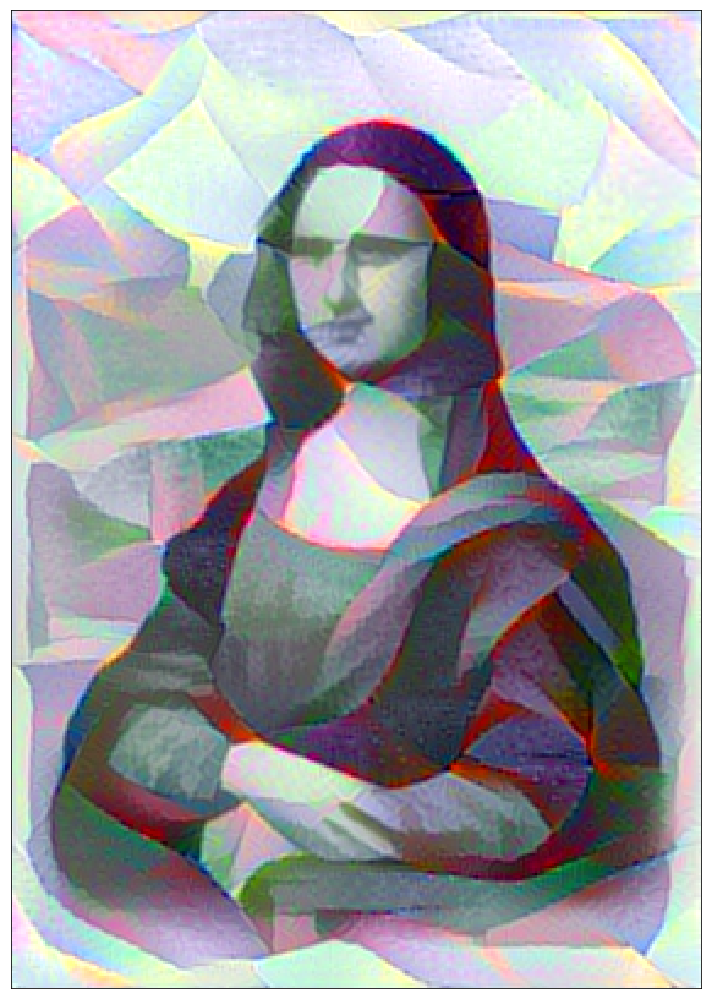

Image saved as output/mona_triangles_1_at_iteration_8.png
Iteration 8 completed in 10s
Start of iteration 9
Current loss value: 12044044000.0


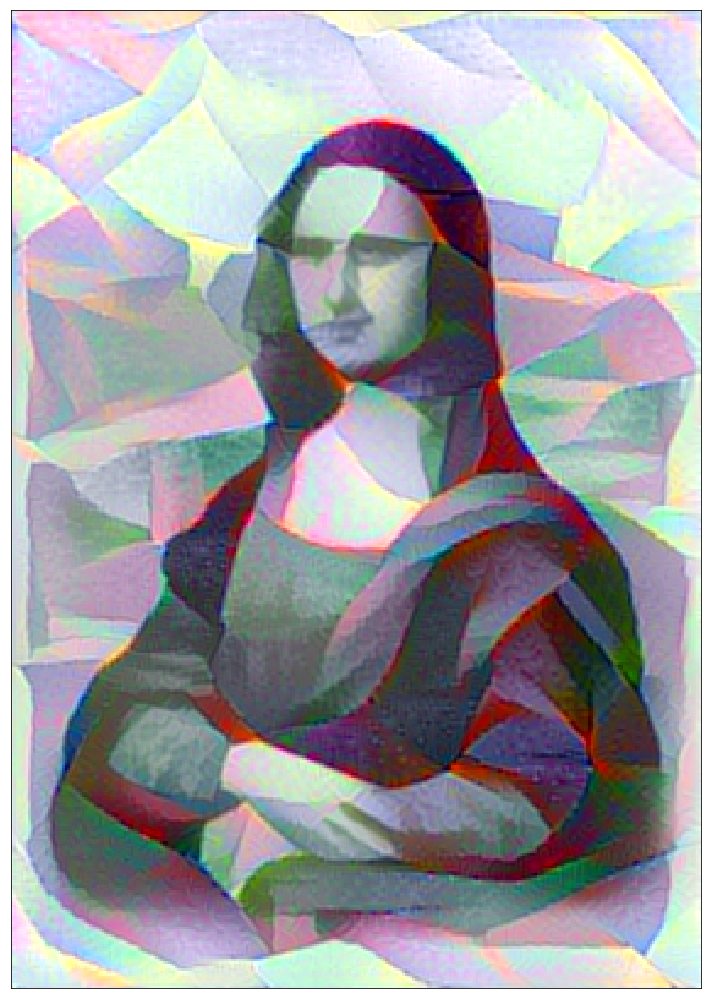

Image saved as output/mona_triangles_1_at_iteration_9.png
Iteration 9 completed in 12s


In [331]:
for i in range(ITERATIONS):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    
    plt.figure(figsize=(18, 18))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    fname = RESULT_PREFIX + '_at_iteration_%d.png' % i
    kpi.save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))